## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [1]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random
import torchvision
import ssim

import shiftpatch_module as sg




### <font style="color:lightblue">Redefine</font>

In [2]:
sg.plt.rcParams['figure.dpi']=223





### <font style="color:lightblue">Configs</font>

In [3]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 2
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 2**8
    ,batchSplit = 2**0
    ,loaderWorkers = 16
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateD = 1e-4
    ,learningRateG = 1e-4
)

sg.DCfg = sg.DCfgClass()


### <font style="color:lightblue">Raw Read</font>

In [4]:
sg.samplingMask = sg.SamplingMask()
sg.samplingVari = sg.SamplingVariations()
sg.trainSet = sg.createTrainSet()
sg.testSet = sg.createTestSet()
sg.testLoader = sg.createDataLoader(sg.createSubSet(sg.testSet),
                                    num_workers=sg.TCfg.loaderWorkers)
sg.refImages, sg.refNoises = sg.createReferences(0)

### <font style="color:lightblue">Show</font>

(1, 887, 824, 630)


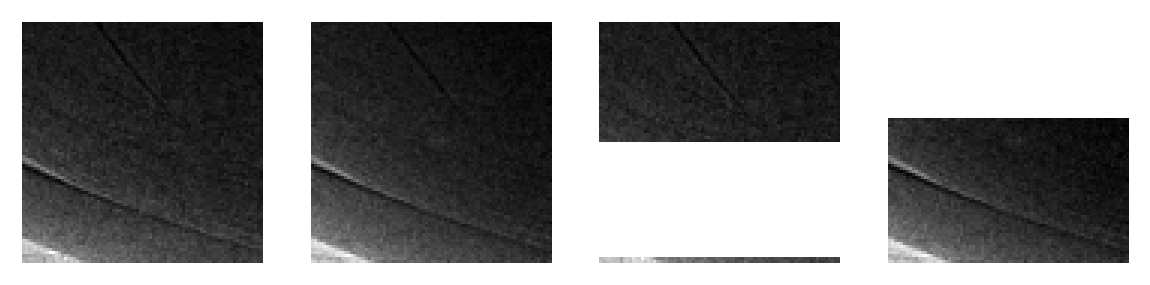

In [5]:

sg.showMe(sg.testSet)

## <font style="color:lightblue">Models</font>

In [6]:
sg.batchNormOpt = { #"track_running_stats" : False,
                    #"momentum" : 0.5,
                  }

### <font style="color:lightblue">Generator</font>

In [7]:
save_interim = False
class Generator(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator, self).__init__(latentChannels=1, inputChannels=2)
        self.amplitude = 1
        self.baseChannels = 16

        self.noise2latent = self.createLatent()

        self.encoders =  nn.ModuleList([
            self.encblock( (self.inputChannels+abs(self.latentChannels)) /self.baseChannels,
                               1, 3, norm=False,),
            self.encblock( 1,  1, 3, norm=True, dopadding=True),
            self.encblock( 1,  2, 3, norm=True, stride=2),
            self.encblock( 2,  2, 3, norm=True, dopadding=True),
            self.encblock( 2,  4, 3, norm=True, stride=2),
            self.encblock( 4,  4, 3, norm=True, dopadding=True),
            self.encblock( 4,  8, 3, norm=True, stride=2),
            self.encblock( 8,  8, 3, norm=True, dopadding=True),
            self.encblock( 8, 16, 3, norm=True, stride=2),
            self.encblock(16, 16, 3, norm=True, dopadding=True),
            ])

        self.fcLink = self.createFClink()

        self.decoders = nn.ModuleList([
            self.decblock(32, 16, 3, norm=True, dopadding=True),
            self.decblock(32,  8, 4, norm=True, stride=2),
            self.decblock(16,  8, 3, norm=True, dopadding=True),
            self.decblock(16,  4, 4, norm=True, stride=2),
            self.decblock( 8,  4, 3, norm=True, dopadding=True),
            self.decblock( 8,  2, 4, norm=True, stride=2),
            self.decblock( 4,  2, 3, norm=True, dopadding=True),
            self.decblock( 4,  1, 4, norm=True, stride=2),
            self.decblock( 2,  1, 3, norm=True, dopadding=True),
            self.decblock( 2,  1, 3, norm=False),
            ])

        self.lastTouch = self.createLastTouch()

        #sg.load_model(self, model_path="saves/mssim_mili/model_gen.pt" )


    def preProc(self, input):
        images, noises = input
        with torch.no_grad() :

            orgDims = images.dim()
            if orgDims == 3 :
                images = images.view(1, *images.shape)
            #procImages = images[:,0:4,...].clone().detach()
            masks = images[:,2:,...]
            images = images[:,0:2,...]

            presentInBoth = ( masks[:,0,...] * masks[:,1,...] > 0 )[:,None]
            invSums = sg.inverseElements( torch.count_nonzero(presentInBoth, dim=(-1,-2)) )
            emeans = ( self.amplitude * images.sum(dim=(-1,-2)) * invSums ) [...,None,None]
            procImages = images * sg.inverseElements(emeans)
            procImages = procImages[:,[0,1],...] * masks \
                       + procImages[:,[1,0],...] * (1-masks) \
                       - 0.5
            #procImages = torch.cat( (procImages, masks), dim=1 )

            noises = noises if noises is not None else None if not self.latentChannels else \
                torch.randn( (images.shape[0], sg.TCfg.latentDim) , device = sg.TCfg.device)

        return (procImages, noises), (emeans, orgDims)







sg.generator = Generator().to(sg.TCfg.device)
sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)
model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0,1],0:4,...], sg.refNoises[[0,1],...]] ] ).__str__()
#print(model_summary)

#checkPoint = torch.load("saves/mssim_mili/checkPoint.pth", map_location=sg.TCfg.device, weights_only=False)
#sg.optimizer_G.load_state_dict(checkPoint['optimizerGen'])
#sg.optimizer_G.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_G, lambda epoch: 1).step()


#_ = sg.testMe(sg.refImages)

### <font style="color:lightblue">Discriminator</font>

In [8]:
sg.discriminatePair = True
class Discriminator(sg.DiscriminatorTemplate):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.baseChannels = 16
        self.body =  nn.Sequential(
            self.encblock( 2/self.baseChannels,
                               1, 3, norm=False,),
            self.encblock( 1,  1, 3, norm=False, dopadding=True),
            self.encblock( 1,  2, 3, norm=False, stride=2),
            self.encblock( 2,  2, 3, norm=False, dopadding=True),
            self.encblock( 2,  4, 3, norm=False, stride=2),
            self.encblock( 4,  4, 3, norm=False, dopadding=True),
            self.encblock( 4,  8, 3, norm=False, stride=2),
            self.encblock( 8,  8, 3, norm=False, dopadding=True),
            self.encblock( 8, 16, 3, norm=False, stride=2),
            self.encblock(16, 16, 3, norm=False, dopadding=True),
            )
        self.head = self.createHead()
        #sg.load_model(self, model_path="/mnt/bctpro.data/anton/shiftpatch/model_1_dis.pt" )

sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[[0],0:2,...] ).__str__()
#print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)

sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD)
#sg.optimizer_D.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_D, lambda epoch: 1).step()



## Loss

In [9]:
sg.noAdv = False
sg.MSSSIM = ssim.MS_SSIM(data_range=2.0, size_average=False, channel=1, win_size=1)
#sg.normTestRec, sg.normTestMSE, sg.normTestL1L = sg.summarizeSet(sg.testLoader)[0:3]
#print(f"{sg.normTestRec:.3e}, {sg.normTestMSE:.3e}, {sg.normTestL1L:.3e}")
#sg.normRec, sg.normMSE, sg.normL1L = sg.summarizeSet(
#                                            sg.createDataLoader(
#                                                sg.createSubSet(sg.trainSet),
#                                                num_workers=sg.TCfg.loaderWorkers))[0:3]
#print(f"{sg.normRec:.3e}, {sg.normMSE:.3e}, {sg.normL1L:.3e}")

#sg.normTestRec, sg.normTestMSE, sg.normTestL1L =  3.185e-03, 3.845e-04, 6.890e-03 # 8.905e-05, 4.314e-04, 7.362e-03
#sg.normRec, sg.normMSE, sg.normL1L = 1.443e-02, 2.267e-03, 1.797e-02 # 1.170e-04, 1.915e-03, 1.639e-02
sg.normTestRec, sg.normTestMSE, sg.normTestL1L = 8.905e-05, 3.845e-04, 6.890e-03 # 4.314e-04, 7.362e-03
sg.normRec, sg.normMSE, sg.normL1L = 1.170e-04, 2.267e-03, 1.797e-02 #1.915e-03, 1.639e-02


# SSIM:   bs0 4.463e-02, 1.044e-02 # bsMean 4.503e-02, 1.025e-02 # bs- 4.448e-02, 1.028e-02 # mskMean 4.739e-02, 1.078e-02
# MSSSIM: bs0 1.431e-02, 3.716e-03 # bsMean 1.443e-02, 3.185e-03 # bs- 1.354e-02, 3.096e-03



## <font style="color:lightblue">Restore checkpoint</font>

In [10]:
#sg.scheduler_G = torch.optim.lr_scheduler.StepLR(sg.optimizer_G, 1, gamma=1-0.001)
#sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=1-0.001)
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.imer, sg.minRecTest, sg.minRecTrain, sg.minTestEpoch, sg.startFrom, sg.resAcc = \
    sg.restoreCheckpoint(savedCheckPoint+".pth")
#sg.startFrom = 0
#sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom = 0, 0, 0, 1, 0
sg.writer = sg.createWriter(sg.TCfg.logDir, True)

#sg.epoch = 0
#sg.imer = 0
#sg.optimizer_G.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_G, lambda epoch: 1).step()
#print(f"Initial LR :{sg.scheduler_G.get_last_lr()[0]/sg.TCfg.learningRateG} {sg.epoch} {sg.imer}")

## Test me

Losses: Rec 2.674e-06, MSE 1.114e-03, L1L 1.399e-02, Dis: 2.482894 (0.051), Adv: 2.577 (0.260), Gen: 3.047e-06, Pixels: 10573.0.


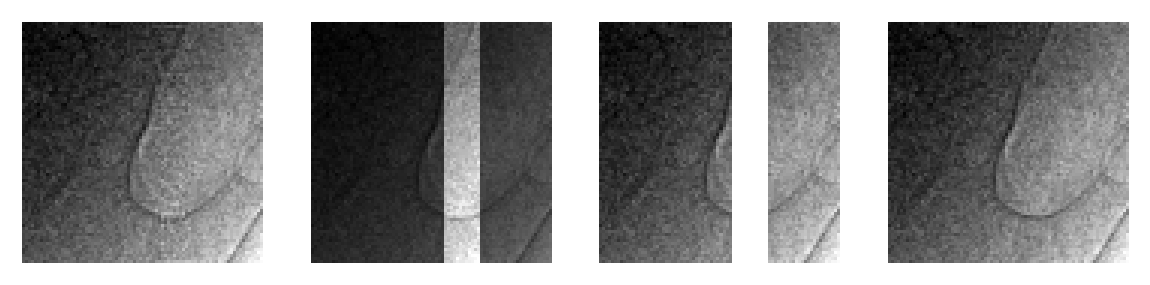

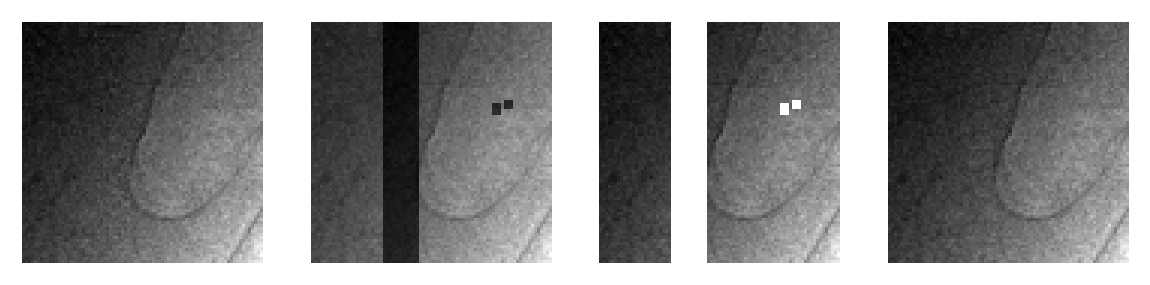

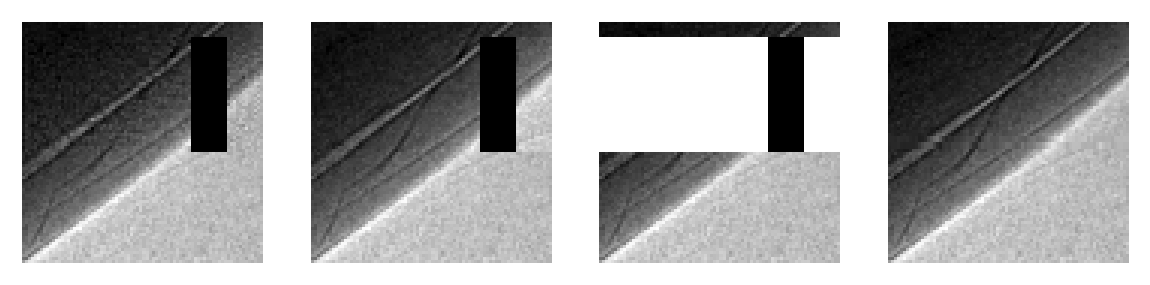

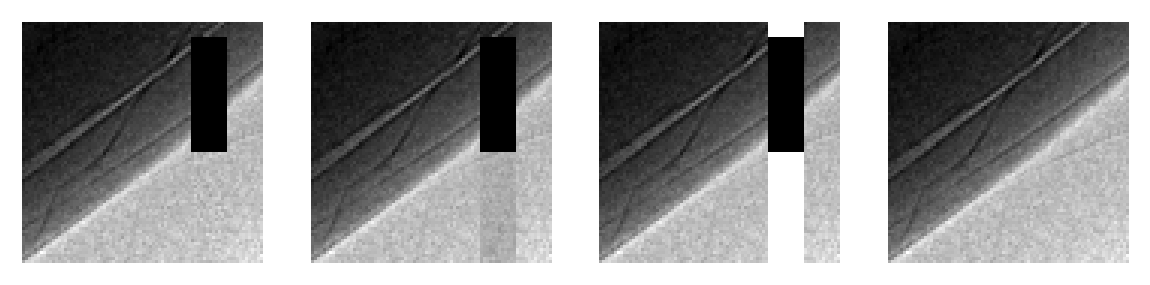

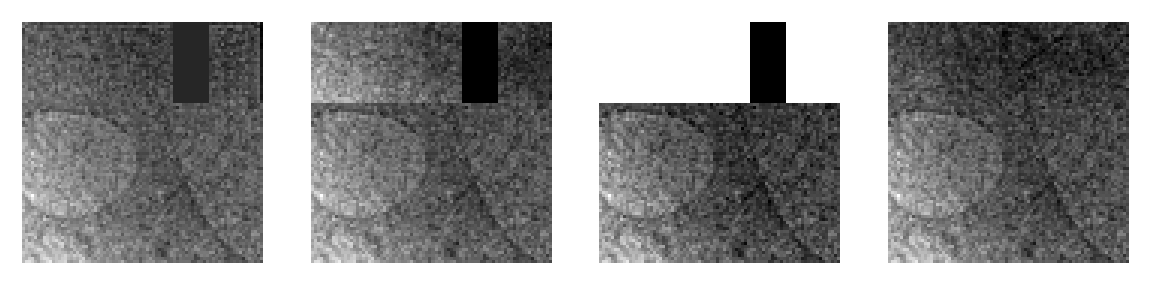

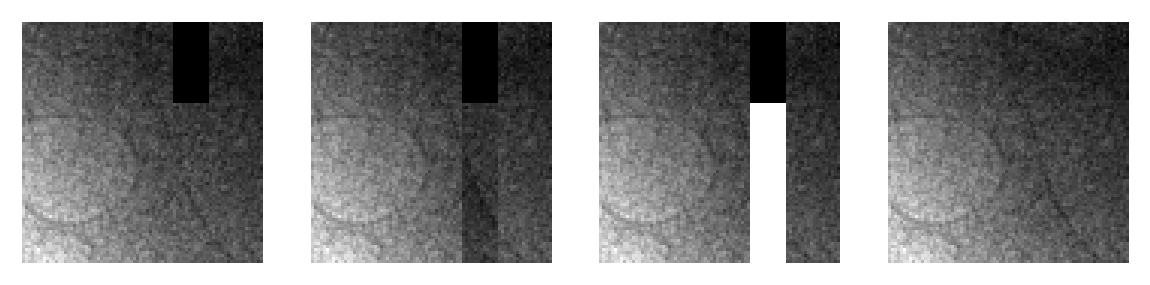

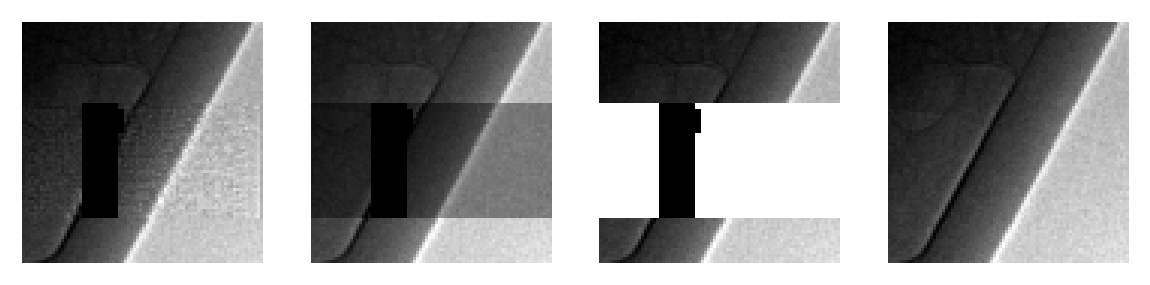

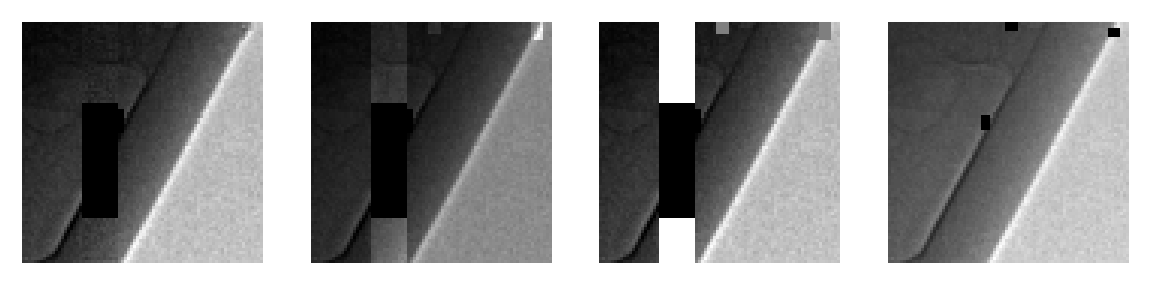

In [11]:


_ = sg.testMe(sg.refImages)


## <font style="color:lightblue">Execute</font>

LR : 9.994e-06 0.100.
Epoch: 156 (155). (Train: 0.098/0.098, Test: 0.973/0.973).
Update.                                  Dis: 0.629 (0.574)  Adv: 0.875 (0.422)  Gen: 0.217  Rec: 0.092 
Random image (1, 1382, 203, 624).        Dis: 2.708 (0.005)  Adv: 5.480 (0.002)  Gen: 0.860  Rec: 0.025 
Reference images.                        Dis: 2.330 (0.056)  Adv: 1.928 (0.338)  Gen: 0.315  Rec: 0.020 


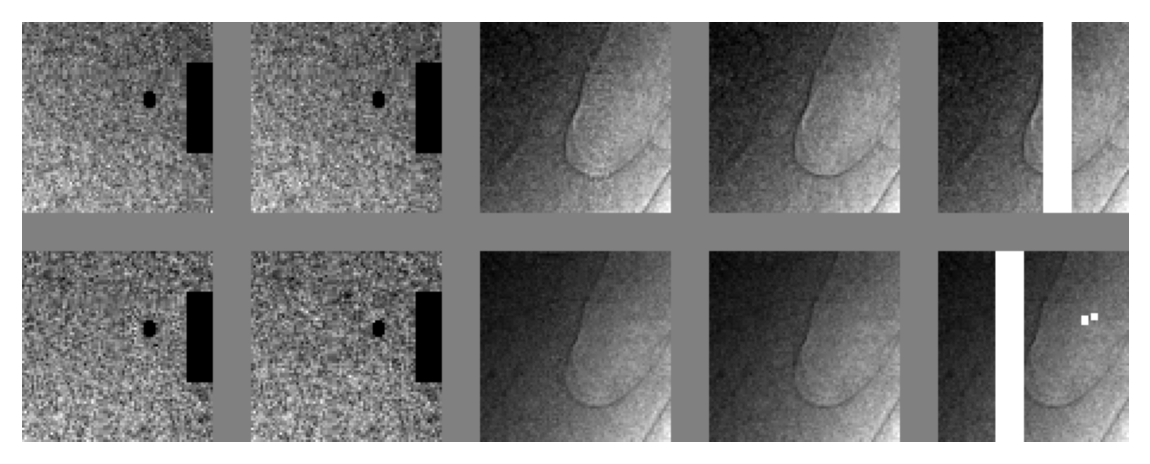

 87%|████████▋ | 10429/12016 [1:05:47<09:58,  2.65it/s]

In [ ]:
#torch.autograd.set_detect_anomaly(True)

#def my_afterEachEpoch(epoch) :
#    if sg.minGEpoch < 600 :
#        return
#    if not sg.dataLoader is None :
#        del sg.dataLoader
#        sg.freeGPUmem()
#    if sg.TCfg.batchSize < 131072 :
#    sg.TCfg.batchSize += round( 0.01 * sg.TCfg.batchSize )
#    sg.dataLoader = sg.createTrainLoader(trainSet, num_workers=24)
#    print("Batch size: ",sg.TCfg.batchSize)
#sg.afterEachEpoch = my_afterEachEpoch
#
#sg.scheduler_G = torch.optim.lr_scheduler.StepLR(sg.optimizer_G, 1, gamma=1-0.001)
#sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=1-0.001)
#def my_beforeReport(_) :
#    lastLR = sg.scheduler_G.get_last_lr()[0]
#    print(f"LR : {lastLR:.3e} {lastLR/sg.TCfg.learningRateG:.3f}")
#    if lastLR  <  0.01 * sg.TCfg.learningRateG :
#        return
#    if sg.scheduler_G is not None :
#        sg.scheduler_G.step()
#    if sg.scheduler_D is not None :
#        sg.scheduler_D.step()
#    return
#sg.beforeReport = my_beforeReport

#def my_beforeReport() :
#    #print(sg.normRec, sg.normMSE, sg.normL1L)
#    #print(sg.normTestRec, sg.normTestMSE, sg.normTestL1L)
#    return
#sg.beforeReport = my_beforeReport

#sg.minRecTest, sg.minRecTrain = 1, 1
sg.ADV_DIF = 1e-2 * 0.002 # 0.008108
sg.scheduler_G = torch.optim.lr_scheduler.StepLR(sg.optimizer_G, 1, gamma=1-0.001)
sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=1-0.001)
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_G, lambda epoch: 1).step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_D, lambda epoch: 1).step()
def my_beforeReport(_) :
    message = ""
    lastLR = sg.scheduler_G.get_last_lr()[0]
    message += f"LR : {lastLR:.3e} {lastLR/sg.TCfg.learningRateG:.3f}."
    if lastLR >  0.1 * sg.TCfg.learningRateG :
        if sg.scheduler_G is not None :
            sg.scheduler_G.step()
        if sg.scheduler_D is not None :
            sg.scheduler_D.step()
    #message += f" ADV/DIF : {sg.ADV_DIF:.3e}."
    #sg.ADV_DIF = max(1e-2, sg.ADV_DIF-1e-5)
#    message += f" Ampl : {sg.generator.amplitude:.3f}."
#    sg.generator.amplitude = min(1, sg.generator.amplitude * (1+5e-3) )
    with open(f"message_{sg.TCfg.exec}.txt", 'a') as file:
        file.write(message + "\n")
    print(message)
    return
sg.beforeReport = my_beforeReport

#sg.TCfg.loaderWorkers = 0 # for debug single threaded
try :
    sg.train(savedCheckPoint)
except :
    #del sg.dataLoader
    #del sg.testLoader
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    sg.epoch -= 1
    raise

# Gen BN; Dis noBN; Dis pair, no masks, SSIMwin 5


## <font style="color:lightblue">Post</font>

In [ ]:
print (sg.generator.amplitude.item(), 2 * torch.sigmoid(sg.generator.amplitude).item() )
sg.initialTest()


In [ ]:
sg.testMe(trainSet, 5)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.saveModels()